### IBM AutoAI-SDK Auto-Generated Notebook v1.13.0

**Note:** Notebook code generated using AutoAI will execute successfully. If code is modified or reordered,   
there is no guarantee it will successfully execute. This pipeline is optimized for the original dataset.  
The pipeline may fail or produce sub-optimium results if used with different data. For different data,  
please consider returning to AutoAI Experiments to generate a new pipeline. Please read our documentation   
for more information:   
<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a>  


Before modifying the pipeline or trying to re-fit the pipeline, consider:   
The notebook converts dataframes to numpy arrays before fitting the pipeline   
(a current restriction of the preprocessor pipeline). The known_values_list is passed by reference   
and populated with categorical values during fit of the preprocessing pipeline. Delete its members before re-fitting.

<a id="content"></a>
## Notebook content

This notebook contains steps and code to demonstrate AutoAI pipeline. This notebook introduces commands for getting data,  
pipeline model, model inspection and testing.

Some familiarity with Python is helpful. This notebook uses Python 3.

## Notebook goals

-  inspection of trained pipeline via graphical vizualization and source code preview
-  pipeline evaluation
-  pipeline deployment and webservice scoring.

## Contents

This notebook contains the following parts:

1.	[Setup](#setup)         
    a.  [AutoAI experiment metadata](#variables_definition)      
2.	[Pipeline inspection](#inspection)      
    a.  [Get historical optimizer instance](#get_hist_and_train)      
    b.  [Get pipeline model](#get_pipeline)      
    c.  [Preview pipeline model as python code](#preview_model_to_python_code)      
    d.  [Visualize pipeline model](#visualize_pipeline)      
    e.  [Read training data](#train_read)        
    f.  [Test pipeline model locally](#test_model)       
3.	[Pipeline refinery and testing (optional)](#refinery)
    a.  [Pipeline definition source code](#pipeline_definition)      
    b.  [Lale library](#lale_library)      
4.	[Deploy and score](#scoring)       
    a.  [Insert WML credentials](#wml_credentials)   
    b.  [Create deployment](#deployment)      
    c.  [Score webservice](#online_scoring)        
    d.  [Delete deployment](#delete_deployment)       
5.  [Authors](#authors)      

<a id="setup"></a>
# Setup

Before you use the sample code in this notebook, you must perform the following setup tasks:
 - `watson-machine-learning-client` uninstallation of the old client
 - `watson-machine-learning-client-V4` installation
 - `autoai-libs` installation/upgrade
 - `lightgbm` or `xgboost` installation/downgrade if they are needed.

In [1]:
!pip uninstall watson-machine-learning-client -y

Uninstalling watson-machine-learning-client-1.0.378:
  Successfully uninstalled watson-machine-learning-client-1.0.378


In [2]:
!pip install -U watson-machine-learning-client-V4

     |████████████████████████████████| 1.3MB 10.5MB/s eta 0:00:01
     |████████████████████████████████| 61kB 26.8MB/s eta 0:00:01
     |████████████████████████████████| 768kB 38.2MB/s eta 0:00:01
     |████████████████████████████████| 225kB 39.6MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/37/9c/c4/a2c610ccb877d37c2cb87a5bfe55845fecffd6bb01bcd5e9d5
  Stored in directory: /home/dsxuser/.cache/pip/wheels/75/93/e6/23071b2c037147a0993d34b64a03e51abca84435fc9cd6a278
  Stored in directory: /home/dsxuser/.cache/pip/wheels/23/d9/d7/43fd95b014eed89466154d8373bf4cffbb3d972de7841e213c
Successfully built ibm-cos-sdk ibm-cos-sdk-core ibm-cos-sdk-s3transfer
  Found existing installation: ibm-cos-sdk-core 2.4.3
    Uninstalling ibm-cos-sdk-core-2.4.3:
      Successfully uninstalled ibm-cos-sdk-core-2.4.3
  Found existing installation: ibm-cos-sdk-s3transfer 2.4.3
    Uninstalling ibm-cos-sdk-s3transfer-2.4.3:
      Successfully uninstalled ibm-cos-sdk-s3transfer-2.4.3
 

In [3]:
!pip install -U autoai-libs
!pip install -U xgboost==0.90

     |████████████████████████████████| 4.1MB 9.5MB/s eta 0:00:01
     |████████████████████████████████| 10.4MB 55.5MB/s eta 0:00:01
     |████████████████████████████████| 14.5MB 59.3MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
  Found existing installation: autoai-libs 1.10.5
    Uninstalling autoai-libs-1.10.5:
      Successfully uninstalled autoai-libs-1.10.5
     |████████████████████████████████| 142.8MB 84.2MB/s eta 0:00:01


<a id="variables_definition"></a>
### AutoAI experiment metadata

This cell defines COS credentials required to retrieve AutoAI pipeline.

In [3]:
# The code was removed by Watson Studio for sharing.

Following cell contains input parameters provided to run the AutoAI experiment in Watson Studio

In [4]:
experiment_metadata = dict(
   prediction_type='regression',
   prediction_column='RF',
   test_size=0.15,
   scoring='neg_root_mean_squared_error',
   csv_separator=',',
   random_state=33,
   excel_sheet=0,
   max_number_of_estimators=3,
   training_data_reference = training_data_reference,
   training_result_reference = training_result_reference)

pipeline_name='Pipeline_4'

<a id="inspection"></a>
## Pipeline inspection
In this section you will get the trained pipeline model from the AutoAI experiment and inspect it.  
You will see pipeline as a pythone code, graphically visualized and at the end, you will perform a local test.


<a id="get_hist_and_train"></a>
### Get historical optimizer instance

The next cell contains code for retrieving fitted optimizer.

In [5]:
from watson_machine_learning_client.experiment import AutoAI

optimizer = AutoAI().runs.get_optimizer(metadata=experiment_metadata)

<a id="get_pipeline"></a>
### Get pipeline model

The following cell loads selected AutoAI pipeline model. If you want to get pure scikit-learn pipeline specify `as_type='sklearn'` parameter. By default enriched scikit-learn pipeline is returned `as_type='lale'`.

In [6]:
pipeline_model = optimizer.get_pipeline(pipeline_name=pipeline_name)

<a id="preview_model_to_python_code"></a>
### Preview pipeline model as python code
In the next cell, downloaded pipeline model could be previewed as a python code.  
You will be able to see what exact steps are involved in model creation.

In [8]:
pipeline_model.pretty_print(combinators=False, ipython_display=True)

```python
from autoai_libs.transformers.exportable import ColumnSelector
from lale.lib.autoai_libs import NumpyColumnSelector
from lale.lib.autoai_libs import FloatStr2Float
from lale.lib.autoai_libs import NumpyReplaceMissingValues
from lale.lib.autoai_libs import NumImputer
from lale.lib.autoai_libs import OptStandardScaler
from lale.lib.autoai_libs import float32_transform
from lale.lib.autoai_libs import TA2
import numpy as np
import autoai_libs.utils.fc_methods
from lale.lib.autoai_libs import FS1
from xgboost import XGBRegressor
from lale.operators import make_pipeline

column_selector = ColumnSelector(columns_indices_list=[1, 2, 3, 4, 5, 6, 7, 8])
numpy_column_selector = NumpyColumnSelector(columns=[0, 1, 2, 3, 4, 5, 6, 7])
float_str2_float = FloatStr2Float(dtypes_list=['float_num', 'float_int_num', 'float_num', 'float_int_num', 'float_num', 'float_int_num', 'float_int_num', 'float_int_num'], missing_values_reference_list=[])
numpy_replace_missing_values = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
num_imputer = NumImputer(missing_values=float('nan'), strategy='median')
opt_standard_scaler = OptStandardScaler(num_scaler_copy=None, num_scaler_with_mean=None, num_scaler_with_std=None, use_scaler_flag=False)
ta2_0 = TA2(fun=np.multiply, name='product', datatypes1=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical], datatypes2=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['K', 'T', 'API', 'Pi', 'Uoi, cp', 'Rsi', 'OOIP', 'Produced'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_0 = FS1(cols_ids_must_keep=range(0, 8), additional_col_count_to_keep=8, ptype='regression')
ta2_1 = TA2(fun=np.true_divide, name='divide', datatypes1=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical], datatypes2=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['K', 'T', 'API', 'Pi', 'Uoi, cp', 'Rsi', 'OOIP', 'Produced', 'product(T__Produced)', 'product(API__Produced)', 'product(Pi__Produced)', 'product(Rsi__Produced)', 'product(Produced__T)', 'product(Produced__API)', 'product(Produced__Pi)', 'product(Produced__Rsi)'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_1 = FS1(cols_ids_must_keep=range(0, 8), additional_col_count_to_keep=8, ptype='regression')
xgb_regressor = XGBRegressor(learning_rate=0.04539783288295145, max_depth=2, min_child_weight=2, missing=float('nan'), n_estimators=1399, random_state=33, reg_alpha=0.006189567604077665, reg_lambda=0.6696073626806818, subsample=0.9924292248704613)
pipeline = make_pipeline(column_selector, numpy_column_selector, float_str2_float, numpy_replace_missing_values, num_imputer, opt_standard_scaler, float32_transform(), ta2_0, fs1_0, ta2_1, fs1_1, xgb_regressor)
```

<a id="visualize_pipeline"></a>
### Visualize pipeline model

Preview pipeline model stages as graph. Each node's name links to detailed description of the stage.


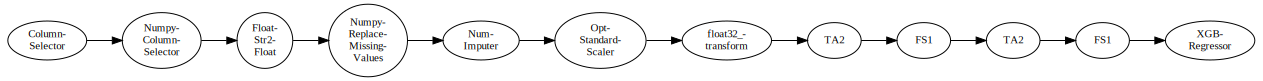

In [9]:
pipeline_model.visualize()

<a id="train_read"></a>
### Read training data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

In [10]:
train_df = optimizer.get_data_connections()[0].read()
test_df = train_df.sample(n=5).drop([experiment_metadata['prediction_column']], axis=1)

<a id="test_model"></a>
### Test pipeline model locally
You can predict target value using trained AutoAI model by calling `predict()`.

In [11]:
y_pred = pipeline_model.predict(test_df.values)
print(y_pred)

[0.22992662 0.30047667 0.11005026 0.24948955 0.1914751 ]


<a id="refinery"></a>
## Pipeline refinery and testing (optional)

In this section you will learn how to refine and retrain the best pipeline returned by AutoAI.
It can be performed by:
 - modifying pipeline definition source code
 - using [lale](https://lale.readthedocs.io/en/latest/) library for semi-automated data science

**Note**: In order to run this section change following cells to 'code' cell.

<a id="pipeline_definition"></a>
### Pipeline definition source code
Following cell lets you experiment with pipeline definition in python, e.g. change steps parameters.

It will inject pipeline definition to the next cell.

In [12]:
pipeline_model.pretty_print(combinators=False, ipython_display='input')

In [13]:
# generated by pretty_print(ipython_display='input') from previous cell
from autoai_libs.transformers.exportable import ColumnSelector
from lale.lib.autoai_libs import NumpyColumnSelector
from lale.lib.autoai_libs import FloatStr2Float
from lale.lib.autoai_libs import NumpyReplaceMissingValues
from lale.lib.autoai_libs import NumImputer
from lale.lib.autoai_libs import OptStandardScaler
from lale.lib.autoai_libs import float32_transform
from lale.lib.autoai_libs import TA2
import numpy as np
import autoai_libs.utils.fc_methods
from lale.lib.autoai_libs import FS1
from xgboost import XGBRegressor
from lale.operators import make_pipeline

column_selector = ColumnSelector(columns_indices_list=[1, 2, 3, 4, 5, 6, 7, 8])
numpy_column_selector = NumpyColumnSelector(columns=[0, 1, 2, 3, 4, 5, 6, 7])
float_str2_float = FloatStr2Float(dtypes_list=['float_num', 'float_int_num', 'float_num', 'float_int_num', 'float_num', 'float_int_num', 'float_int_num', 'float_int_num'], missing_values_reference_list=[])
numpy_replace_missing_values = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
num_imputer = NumImputer(missing_values=float('nan'), strategy='median')
opt_standard_scaler = OptStandardScaler(num_scaler_copy=None, num_scaler_with_mean=None, num_scaler_with_std=None, use_scaler_flag=False)
ta2_0 = TA2(fun=np.multiply, name='product', datatypes1=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical], datatypes2=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['K', 'T', 'API', 'Pi', 'Uoi, cp', 'Rsi', 'OOIP', 'Produced'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_0 = FS1(cols_ids_must_keep=range(0, 8), additional_col_count_to_keep=8, ptype='regression')
ta2_1 = TA2(fun=np.true_divide, name='divide', datatypes1=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical], datatypes2=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['K', 'T', 'API', 'Pi', 'Uoi, cp', 'Rsi', 'OOIP', 'Produced', 'product(T__Produced)', 'product(API__Produced)', 'product(Pi__Produced)', 'product(Rsi__Produced)', 'product(Produced__T)', 'product(Produced__API)', 'product(Produced__Pi)', 'product(Produced__Rsi)'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_1 = FS1(cols_ids_must_keep=range(0, 8), additional_col_count_to_keep=8, ptype='regression')
xgb_regressor = XGBRegressor(learning_rate=0.04539783288295145, max_depth=2, min_child_weight=2, missing=float('nan'), n_estimators=1399, random_state=33, reg_alpha=0.006189567604077665, reg_lambda=0.6696073626806818, subsample=0.9924292248704613)
pipeline = make_pipeline(column_selector, numpy_column_selector, float_str2_float, numpy_replace_missing_values, num_imputer, opt_standard_scaler, float32_transform(), ta2_0, fs1_0, ta2_1, fs1_1, xgb_regressor)

In [14]:
# generated by pretty_print(ipython_display='input') from previous cell
from autoai_libs.transformers.exportable import ColumnSelector
from lale.lib.autoai_libs import NumpyColumnSelector
from lale.lib.autoai_libs import FloatStr2Float
from lale.lib.autoai_libs import NumpyReplaceMissingValues
from lale.lib.autoai_libs import NumImputer
from lale.lib.autoai_libs import OptStandardScaler
from lale.lib.autoai_libs import float32_transform
from lale.lib.autoai_libs import TA2
import numpy as np
import autoai_libs.utils.fc_methods
from lale.lib.autoai_libs import FS1
from xgboost import XGBRegressor
from lale.operators import make_pipeline

column_selector = ColumnSelector(columns_indices_list=[1, 2, 3, 4, 5, 6, 7, 8])
numpy_column_selector = NumpyColumnSelector(columns=[0, 1, 2, 3, 4, 5, 6, 7])
float_str2_float = FloatStr2Float(dtypes_list=['float_num', 'float_int_num', 'float_num', 'float_int_num', 'float_num', 'float_int_num', 'float_int_num', 'float_int_num'], missing_values_reference_list=[])
numpy_replace_missing_values = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
num_imputer = NumImputer(missing_values=float('nan'), strategy='median')
opt_standard_scaler = OptStandardScaler(num_scaler_copy=None, num_scaler_with_mean=None, num_scaler_with_std=None, use_scaler_flag=False)
ta2_0 = TA2(fun=np.multiply, name='product', datatypes1=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical], datatypes2=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['K', 'T', 'API', 'Pi', 'Uoi, cp', 'Rsi', 'OOIP', 'Produced'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_0 = FS1(cols_ids_must_keep=range(0, 8), additional_col_count_to_keep=8, ptype='regression')
ta2_1 = TA2(fun=np.true_divide, name='divide', datatypes1=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints1=[autoai_libs.utils.fc_methods.is_not_categorical], datatypes2=['intc', 'intp', 'int_', 'uint8', 'uint16', 'uint32', 'uint64', 'int8', 'int16', 'int32', 'int64', 'short', 'long', 'longlong', 'float16', 'float32', 'float64'], feat_constraints2=[autoai_libs.utils.fc_methods.is_not_categorical], col_names=['K', 'T', 'API', 'Pi', 'Uoi, cp', 'Rsi', 'OOIP', 'Produced', 'product(T__Produced)', 'product(API__Produced)', 'product(Pi__Produced)', 'product(Rsi__Produced)', 'product(Produced__T)', 'product(Produced__API)', 'product(Produced__Pi)', 'product(Produced__Rsi)'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1_1 = FS1(cols_ids_must_keep=range(0, 8), additional_col_count_to_keep=8, ptype='regression')
xgb_regressor = XGBRegressor(learning_rate=0.04539783288295145, max_depth=2, min_child_weight=2, missing=float('nan'), n_estimators=1399, random_state=33, reg_alpha=0.006189567604077665, reg_lambda=0.6696073626806818, silent=True, subsample=0.9924292248704613, verbosity=0)
pipeline = make_pipeline(column_selector, numpy_column_selector, float_str2_float, numpy_replace_missing_values, num_imputer, opt_standard_scaler, float32_transform(), ta2_0, fs1_0, ta2_1, fs1_1, xgb_regressor)

<a id="lale_library"></a>
### Lale library

**Note**: This is only an exemplary usage of lale package. You can import more different estimators to refine downloaded pipeline model.

#### Import estimators

In [15]:
from sklearn.linear_model import LinearRegression as E1
from sklearn.tree import DecisionTreeRegressor as E2
from sklearn.neighbors import KNeighborsRegressor as E3
from lale.lib.lale import Hyperopt
from lale.operators import TrainedPipeline
from lale import wrap_imported_operators
from lale.helpers import import_from_sklearn_pipeline
wrap_imported_operators()

<a id="decomposition_definition"></a>
#### Pipeline decomposition and new definition
In this step the last stage from pipeline is removed.

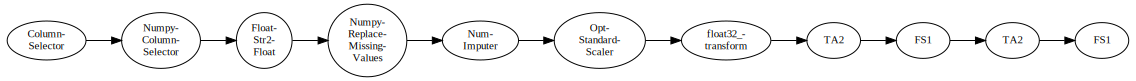

In [16]:
prefix = pipeline_model.remove_last().freeze_trainable()
prefix.visualize()

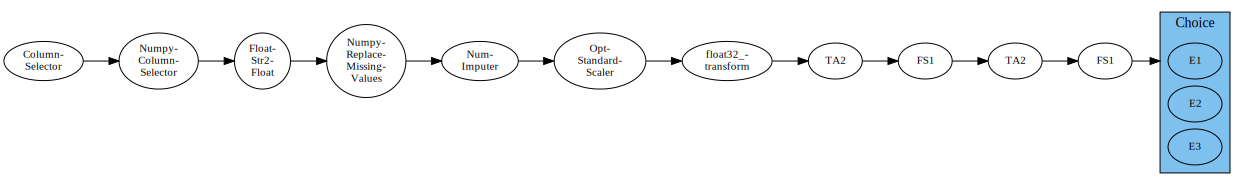

In [17]:
new_pipeline = prefix >> (E1 | E2 | E3)
new_pipeline.visualize()

<a id="new_optimizer"></a>
#### New optimizer `hyperopt` configuration and training

This section can introduce other results than the original one and it should be used
by more advanced users.

New pipeline is re-trained by passing train data to it and calling `fit` method.

Following cell performs dataset split for refined pipeline model.

In [18]:
from sklearn.model_selection import train_test_split

train_X = train_df.drop([experiment_metadata['prediction_column']], axis=1).values
train_y = train_df[experiment_metadata['prediction_column']].values

train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=experiment_metadata['test_size'],
                                                    random_state=experiment_metadata['random_state'])

In [19]:
hyperopt = Hyperopt(estimator=new_pipeline, cv=3, max_evals=20, scoring='r2')
fitted_hyperopt = hyperopt.fit(train_X, train_y)

100%|██████████| 20/20 [01:28<00:00,  4.39s/trial, best loss: -0.9987936806874048]


In [20]:
hyperopt_pipeline = fitted_hyperopt.get_pipeline()
new_pipeline = hyperopt_pipeline.export_to_sklearn_pipeline()

In [21]:
prediction = new_pipeline.predict(test_X)

In [22]:
from sklearn.metrics import r2_score

score = r2_score(y_true=test_y, y_pred=prediction)
print('r2_score: ', score)

r2_score:  0.9977553319597785


<a id="scoring"></a>
## Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

<a id="wml_credentials"></a>
### Connect to WML client in order to create deployment
**Action:** Next you will need credentials for Watson Machine Learning and training run_id:
 - go to [Cloud catalog resources list](https://cloud.ibm.com/resources)
 - click on Services and chose Machine Learning service. Once you are there
 - click the **Service Credentials** link on the left side of the screen
 - click to expand specific credentials name.
 - copy and paste your WML credentials into the cell below

*Take in mind that WML Service instance should be the same as used to generate this notebook.*

In [23]:
# The code was removed by Watson Studio for sharing.

<a id="deployment"></a>

### Create deployment
 **Action**: If you want to deploy refined pipeline please change the `pipeline_model` to
`new_pipeline`.
If you prefer you can also change the `deployment_name`.

In [24]:
from watson_machine_learning_client.deployment import WebService


service = WebService(wml_credentials)
service.create(
    model=pipeline_model,
    metadata=experiment_metadata,
    deployment_name=f'{pipeline_name}_webservice'
)

Preparing an AutoAI Deployment...
Published model uid: 44c250cb-2c56-4e7b-baf9-88a5a001d155
Deploying model 44c250cb-2c56-4e7b-baf9-88a5a001d155 using V4 client.


#######################################################################################

Synchronous deployment creation for uid: '44c250cb-2c56-4e7b-baf9-88a5a001d155' started

#######################################################################################


initializing........
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ad75ba87-62f2-4524-9dfb-446c085329b6'
------------------------------------------------------------------------------------------------




Deployment object could be printed to show basic information:

In [25]:
print(service)

name: Pipeline_4_webservice, id: ad75ba87-62f2-4524-9dfb-446c085329b6, scoring_url: https://jp-tok.ml.cloud.ibm.com/v4/deployments/ad75ba87-62f2-4524-9dfb-446c085329b6/predictions, asset_id: 44c250cb-2c56-4e7b-baf9-88a5a001d155


To be able to show all available information about deployment use `.get_params()` method:

In [26]:
service.get_params()

{'entity': {'asset': {'href': '/v4/models/44c250cb-2c56-4e7b-baf9-88a5a001d155?rev=b81f3a32-f0e5-43dc-8ad3-89bdd036174f',
   'id': '44c250cb-2c56-4e7b-baf9-88a5a001d155',
   'rev': 'b81f3a32-f0e5-43dc-8ad3-89bdd036174f'},
  'custom': {},
  'description': '',
  'name': 'Pipeline_4_webservice',
  'online': {},
  'status': {'online_url': {'url': 'https://jp-tok.ml.cloud.ibm.com/v4/deployments/ad75ba87-62f2-4524-9dfb-446c085329b6/predictions'},
   'state': 'ready'}},
 'metadata': {'created_at': '2020-08-26T18:47:27.300Z',
  'description': '',
  'guid': 'ad75ba87-62f2-4524-9dfb-446c085329b6',
  'href': '/v4/deployments/ad75ba87-62f2-4524-9dfb-446c085329b6',
  'id': 'ad75ba87-62f2-4524-9dfb-446c085329b6',
  'modified_at': '2020-08-26T18:47:27.300Z',
  'name': 'Pipeline_4_webservice',
  'parent': {'href': ''}}}

<a id="online_scoring"></a>
### Score webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [27]:
predictions = service.score(payload=test_df)
predictions

{'predictions': [{'fields': ['prediction'],
   'values': [[0.22992661595344543],
    [0.30047667026519775],
    [0.1100502610206604],
    [0.24948954582214355],
    [0.19147509336471558]]}]}

If you want to work with the webservice in external Python application you can retrieve the service object by:
 - initialize service by `service = WebService(wml_credentials)`
 - get deployment_id by `service.list()` method
 - get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

In [28]:
# The code was removed by Watson Studio for sharing.

,NUMBER,K,T,API,Pi,"Uoi, cp",Rsi,OOIP,Produced,RF
0,10,379.0,203,43.0,3425,0.92,256,915,179,0.20
1,11,35.0,135,47.0,2230,0.31,663,180,45,0.25
2,12,3.0,108,43.0,3000,0.38,1120,305,56,0.18
3,56,26.6,115,42.0,1400,1.00,420,595,119,0.20
4,57,16.0,104,30.0,3000,3.00,377,625,78,0.12


In [37]:
import urllib3, requests, json

# Get an IAM token from IBM Cloud
url     = "https://iam.bluemix.net/oidc/token"
headers = { "Content-Type" : "application/x-www-form-urlencoded" }
data    = "apikey=" + wml_credentials["apikey"] + "&grant_type=urn:ibm:params:oauth:grant-type:apikey"
IBM_cloud_iam_uid = "bx"
IBM_cloud_iam_pwd = "bx"
response  = requests.post( url, headers=headers, data=data, auth=( IBM_cloud_iam_uid, IBM_cloud_iam_pwd ) )

if 200 != response.status_code:
    print( response.status_code )
    print( response.reason )
else:
    iam_token = response.json()["access_token"]
    
# NOTE: generate iam_token and retrieve ml_instance_id based on provided documentation	
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + iam_token, 'ML-Instance-ID': wml_credentials["instance_id"]}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = {"input_data": [{"fields": ["NUMBER", "K", "T", "API", "Pi", "Uoi, cp", "Rsi", "OOIP", "Produced"], "values": ["RF"]}]}

response_scoring = requests.post('https://jp-tok.ml.cloud.ibm.com/v4/deployments/ffc17796-a464-4dd7-879d-05a1cf2ad482/predictions', json=payload_scoring, headers=header)
print("Scoring response")
print(json.loads(response_scoring.text))

Scoring response
{'trace': '41f2b25777dbd36720b0d14eb4f37c12', 'errors': [{'code': 'invalid_payload', 'message': 'Scoring payload field `values` is not in valid format. Excepted format is Multidimensional Json Array'}]}


In [48]:
predictions = service.score(payload=df_data_1)
print (predictions)

{'predictions': [{'fields': ['prediction'], 'values': [[0.19919219613075256], [0.2498520314693451], [0.18996736407279968], [0.20020869374275208], [0.12990379333496094], [0.19924426078796387], [0.1896670162677765], [0.15996813774108887], [0.1898047924041748], [0.16004785895347595], [0.17932626605033875], [0.3093310296535492], [0.16996201872825623], [0.22989964485168457], [0.17998358607292175], [0.21012753248214722], [0.24948954582214355], [0.17013779282569885], [0.22989964485168457], [0.1899050772190094]]}]}


In [56]:
# Define a dictionary containing Predictions 

New_RF ={'values': [0.19919219613075256, 0.2498520314693451, 0.18996736407279968, 0.20020869374275208, 0.12990379333496094, 0.19924426078796387, 0.1896670162677765, 0.15996813774108887, 0.1898047924041748, 0.16004785895347595, 0.17932626605033875, 0.3093310296535492, 0.16996201872825623, 0.22989964485168457, 0.17998358607292175, 0.21012753248214722, 0.24948954582214355, 0.17013779282569885, 0.22989964485168457, 0.1899050772190094]}
df = pd.DataFrame(New_RF)

In [57]:
df_data_1['NewRF'] = df

In [58]:
df_data_1.head(20)

,NUMBER,K,T,API,Pi,"Uoi, cp",Rsi,OOIP,Produced,RF,NewRF
0,10,379.0,203,43.0,3425,0.92,256,915,179,0.20,0.199192
1,11,35.0,135,47.0,2230,0.31,663,180,45,0.25,0.249852
2,12,3.0,108,43.0,3000,0.38,1120,305,56,0.18,0.189967
3,56,26.6,115,42.0,1400,1.00,420,595,119,0.20,0.200209
4,57,16.0,104,30.0,3000,3.00,377,625,78,0.12,0.129904
5,58,10.3,120,45.0,2170,0.35,918,345,68,0.20,0.199244
6,59,1.0,182,39.0,2760,0.27,850,172,32,0.19,0.189667
7,60,5.1,190,38.0,2912,0.45,800,312,49,0.16,0.159968
8,61,6.5,172,40.0,2748,0.29,1236,170,32,0.19,0.189805
9,62,16.1,114,36.0,1800,1.89,800,324,51,0.16,0.160048


In [59]:
score = r2_score(y_true=df_data_1['RF'], y_pred=df_data_1['NewRF'])
print('r2_score: ', score)

r2_score:  0.9871355472260656


<a id="delete_deployment"></a>
### Delete deployment

You can delete an existing deployment by calling `service.delete()`.

<a id="authors"></a>
### Author: Daniel Asante Otchere
Daniel is currently a PhD student at the Universiti Teknologi PETRONAS in Malaysia undertaking research in petroleum engineering, enhanced oil recovery.  He has a masters degree in petroleum geoscience from the University of Manchester and is highly interested in the application of AI in the petroleum industry largely due to the large amount of complex data in the industry. He sees the application of data analysis and machine learning to be a way to utilise all available data to their full potential for the understanding of the subsurface thereby making it easier for companies to reduce the costs involved in gathering data and investing in training of their human resources in the field of AI.

Licensed Materials - Copyright © 2020 IBM. This notebook and its source code are released under the terms of the ILAN License.
Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs  
(or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms),  
such agreements located in the link below. Specifically, the Source Components and Sample Materials clause  
included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="http://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BHU2B7&title=IBM%20Watson%20Studio%20Auto-generated%20Notebook%20V2.1">License Terms</a>  

___